# Boolean Networks - Assignment 3

Focus: Network dynamics, state spaces, and predictive modeling

###  Setup and Required Libraries


In [161]:
#  Setup and Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

---

### Helper functions to create a Boolean network
Run the following code snippet so the basic functions are available.

In [162]:
# 🟢 Helper class to build and simulate boolean network

class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)



---



## Functions used for analysis
The following functions are used to create and analyse networks. `create_regulatory_network` creates a network with either standard rules or mutated rules. `scenario_analysis` tests all 3 scenarios from practical. `attractor_search` and `basin_search` find all attractors for each mutated network.
 


In [163]:
#  Create the regulatory network

nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']

def create_regulatory_network(p53_knockout=False, MYC_amplification=False, MDM2_overexpression=False, CDK2_knockout=False):
    """Build the core network and optionally apply mutations."""
    network = BooleanNetwork(nodes)

    # Define Boolean rules (based on real biology, simplified)
    network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
    network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
    network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
    network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
    network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
    network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
    network.add_rule('Growth', lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
    network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

    if p53_knockout:
        network.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)")
    if MYC_amplification:
        network.add_rule('MYC', lambda s: True, "MYC = AMPLIFIED (always ON)")
    if MDM2_overexpression:
        network.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)")
    if CDK2_knockout:
        network.add_rule('CDK2', lambda s: False, "CDK2 = KNOCKOUT (always OFF)")
        

    print("Rules:")
    for node, rule_info in network.rules.items():
        print(f"  {rule_info['description']}")

    return network



Scenario analysis function:

In [164]:
scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}


def scenario_analysis(network, graph_title, gene = 'p53'): #p53 is the used in the normal network practical
    mutant_results = {}
    mutant_node_names = sorted(network.nodes.keys())

    for scenario_name, initial_state in scenarios.items():
        network.set_state(**initial_state)
        with redirect_stdout(io.StringIO()):
            trajectory = network.simulate(steps=8)
        mutant_results[scenario_name] = trajectory

        final_state = trajectory[-1]
        final_dict = {node: int(final_state[i]) for i, node in enumerate(mutant_node_names)}
        print(f"  {scenario_name}: Growth={final_dict['Growth']}, Death={final_dict['Death']}, {gene }={final_dict[gene]}")

    n_scenarios = len(mutant_results)
    fig, axes = plt.subplots(1, n_scenarios, figsize=(5 * n_scenarios, 6))

    if n_scenarios == 1:
        axes = [axes]

    for scenario_idx, (scenario_name, trajectory) in enumerate(mutant_results.items()):
        ax = axes[scenario_idx]
        trajectory_matrix = trajectory.T

        ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
        ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
        ax.set_xlabel('Time Steps', fontsize=10)
        ax.set_ylabel('Network Nodes', fontsize=10)
        ax.set_yticks(range(len(mutant_node_names)))
        ax.set_yticklabels(mutant_node_names, fontsize=9)

        for t in range(trajectory.shape[0]):
            for n in range(len(mutant_node_names)):
                color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
                ax.text(t, n, int(trajectory_matrix[n, t]), ha='center', va='center', color=color, fontweight='bold')

        output_indices = [i for i, name in enumerate(mutant_node_names) if name in ['Growth', 'Death', gene]]
        for output_idx in output_indices:
            ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

    plt.suptitle(f'{graph_title} - Scenario Dynamics', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

Attractor search function:

In [165]:
def attractor_search(network, graph_title, gene = 'p53'): #p53 is the used in the normal network practical
    mutant_attractors = []
    mutant_attractor_info = []
    mutant_max_steps = 15
    mutant_node_names = sorted(network.nodes.keys())
    mutant_all_states = list(product([0, 1], repeat=len(mutant_node_names)))

    print(f'Testing all {len(mutant_all_states)} possible initial states under Mutation of {gene}' )

    for initial_state in mutant_all_states:
        state_dict = {mutant_node_names[i]: initial_state[i] for i in range(len(mutant_node_names))}
        network.set_state(**state_dict)

        with redirect_stdout(io.StringIO()):
            trajectory = network.simulate(steps=mutant_max_steps, record_history=True)

        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(int(x) for x in trajectory[-1])
            if final_state not in mutant_attractors:
                mutant_attractors.append(final_state)

    if not mutant_attractors:
        print('No attractors found for the mutated network.')
    else:
        for idx, attractor in enumerate(mutant_attractors, start=1):
            state_dict = {mutant_node_names[j]: int(attractor[j]) for j in range(len(mutant_node_names))}
            growth_active = state_dict['Growth'] == 1
            death_active = state_dict['Death'] == 1
            gene_active = state_dict[gene] == 1
            dna_damage_active = state_dict['DNA_damage'] == 1

            if growth_active and not death_active:
                if dna_damage_active:
                    interpretation = 'Cancer-like growth despite DNA damage'
                else:
                    interpretation = 'Cancer- like growth in healthy conditions'
            elif death_active and not growth_active:
                interpretation = 'Cell death / apoptosis'
            else:
                interpretation = 'Quiescent or unresolved state'

            mutant_attractor_info.append({
                'state': attractor,
                'interpretation': interpretation,
                'cancer_like': growth_active and not death_active
            })

            print()
            print(f"Attractor {idx}: {list(attractor)}")
            print(f"   Growth: {'ON' if growth_active else 'OFF'} | Death: {'ON' if death_active else 'OFF'} | {gene}: {'ON' if gene_active else 'OFF'} | DNA Damage: {'ON' if dna_damage_active else 'OFF'}")
            print(f"   Interpretation: {interpretation}")

        mutant_attractor_matrix = np.array([list(map(int, att)) for att in mutant_attractors])

        plt.figure(figsize=(10, max(6, len(mutant_attractors))))
        ax = sns.heatmap(
            mutant_attractor_matrix,
            xticklabels=mutant_node_names,
            yticklabels=[f'Attractor {i+1}' for i in range(len(mutant_attractors))],
            cmap='RdYlBu_r',
            cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
            annot=True,
            fmt='d',
            linewidths=0.5,
        )

        plt.title(f'{graph_title} - Attractors', fontsize=14, fontweight='bold')
        plt.xlabel('Network Nodes', fontsize=12)
        plt.ylabel('Attractors', fontsize=12)

        for node in ['Growth', 'Death', gene, 'DNA_damage']:
            if node in mutant_node_names:
                idx = mutant_node_names.index(node)
                ax.axvline(x=idx + 0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

        plt.tight_layout()
        plt.show()
        return mutant_attractors, mutant_attractor_info

Basin analysis function:

In [166]:
def basin_analysis(network, graph_title, mutant_attractors, mutant_attractor_info):
    mutant_max_steps = 15
    mutant_node_names = sorted(network.nodes.keys())
    mutant_all_states = list(product([0, 1], repeat=len(mutant_node_names)))

    if mutant_attractors:
        mutant_basin_data = defaultdict(list)
        mutant_attractor_map = {}
        total_states = len(mutant_all_states)

        for initial_state in mutant_all_states:
            state_dict = {mutant_node_names[i]: initial_state[i] for i in range(len(mutant_node_names))}
            network.set_state(**state_dict)

            with redirect_stdout(io.StringIO()):
                trajectory = network.simulate(steps=mutant_max_steps, record_history=True)

            if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
                final_state = tuple(int(x) for x in trajectory[-1])
                for att_idx, attractor in enumerate(mutant_attractors):
                    if final_state == tuple(int(x) for x in attractor):
                        mutant_basin_data[att_idx].append(initial_state)
                        mutant_attractor_map[initial_state] = att_idx
                        break

        print()
        print(f'Basin sizes under{graph_title}:')
        cancer_like_states = 0
        for att_idx, info in enumerate(mutant_attractor_info):
            basin_size = len(mutant_basin_data[att_idx])
            percentage = (basin_size / total_states) * 100
            print(f"  Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%) -> {info['interpretation']}")
            if info['cancer_like']:
                cancer_like_states += basin_size

        cancer_like_pct = (cancer_like_states / total_states) * 100
        print()
        print(f"Overall, {cancer_like_states} of {total_states} states ({cancer_like_pct:5.1f}%) flow into cancer-like attractors.")

        basin_sizes = [len(mutant_basin_data[i]) for i in range(len(mutant_attractors))]
        basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
        colors = plt.cm.Set3(np.linspace(0, 1, len(mutant_attractors)))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.pie(basin_sizes, labels=basin_labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title(f'{graph_title} - Basin of Attraction Sizes', fontsize=12, fontweight='bold')

        bars = ax2.bar([f'Attractor {i+1}' for i in range(len(mutant_attractors))], basin_sizes, color=colors, alpha=0.7)
        ax2.set_title(f'{graph_title} - Basin Size Comparison', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Number of Initial States', fontsize=10)
        ax2.set_xlabel('Attractors', fontsize=10)

        for bar, size in zip(bars, basin_sizes):
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{size}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()
    else:
        print('Skipping basin analysis because no attractors were found.')

-------

## Normal network

In [167]:
#create the network
network = create_regulatory_network() 
print(f"{network.rules['p53']['description']}")

Rules:
  DNA_damage = INPUT (constant)
  p21 = p53
  MYC = (NOT p53) AND (NOT p21)
  CDK2 = MYC AND (NOT p21) AND (NOT p53)
  MDM2 = MYC
  p53 = DNA_damage AND (NOT MDM2)
  Growth = CDK2 AND MYC AND (NOT p53)
  Death = p53 AND DNA_damage AND (NOT Growth)
p53 = DNA_damage AND (NOT MDM2)


### Scenario Analysis for the Normal Network

Reuse the three practical scenarios to check how it effects the network.

  Healthy Cell: Growth=1, Death=0, p53=0
  Stressed Cell: Growth=0, Death=1, p53=1
  Oncogene Hijacked Cell: Growth=1, Death=0, p53=0


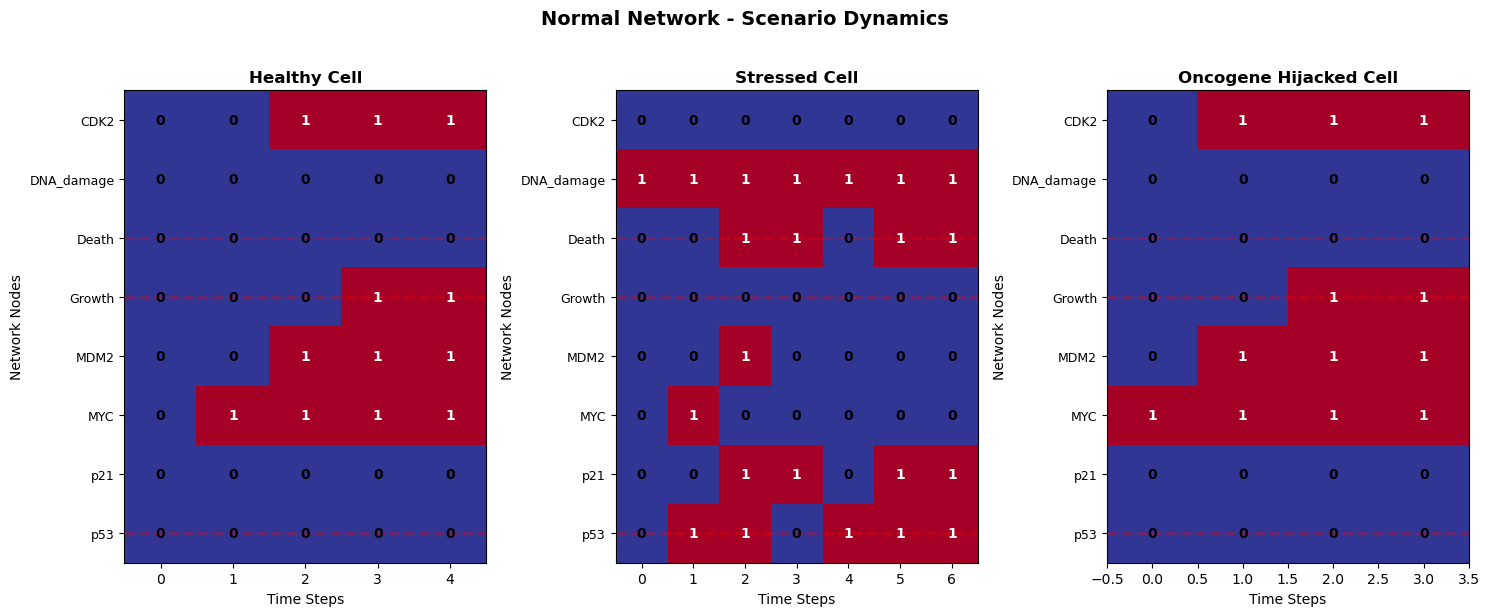

In [168]:
graph_title = 'Normal Network'
scenario_analysis(network, graph_title)

### Attractor Analysis for the Normal Network

Scan the full state space to see which steady states remain reachable and how often the network falls into cancer-like behaviour.

Testing all 256 possible initial states under Mutation of p53

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | p53: OFF | DNA Damage: OFF
   Interpretation: Cancer- like growth in healthy conditions

Attractor 2: [0, 1, 1, 0, 0, 0, 1, 1]
   Growth: OFF | Death: ON | p53: ON | DNA Damage: ON
   Interpretation: Cell death / apoptosis

Attractor 3: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | p53: OFF | DNA Damage: ON
   Interpretation: Cancer-like growth despite DNA damage


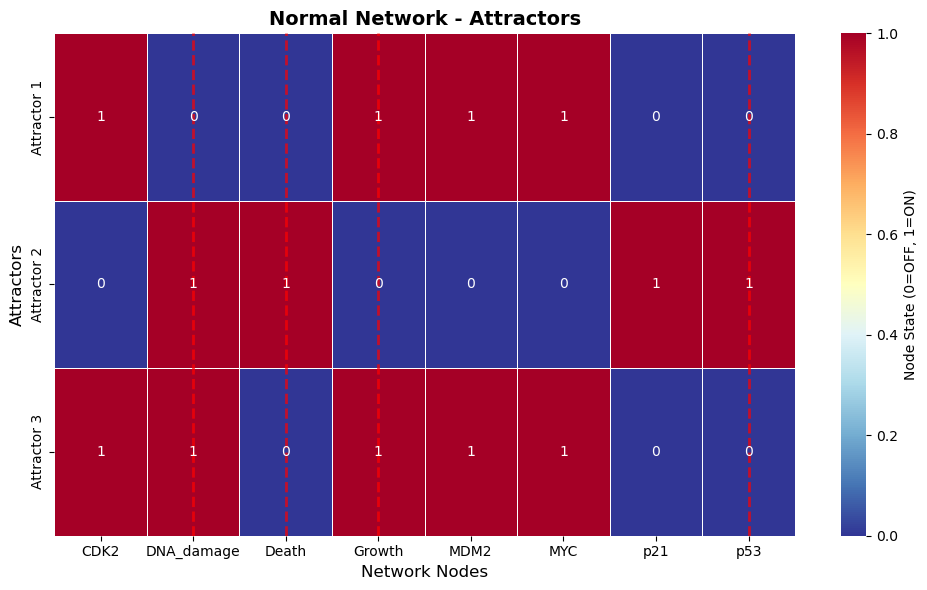

In [169]:
mutant_attractors, mutant_attractor_info = attractor_search(network, graph_title)


Basin sizes underNormal Network:
  Attractor 1: 128 states ( 50.0%) -> Cancer- like growth in healthy conditions
  Attractor 2: 120 states ( 46.9%) -> Cell death / apoptosis
  Attractor 3:   8 states (  3.1%) -> Cancer-like growth despite DNA damage

Overall, 136 of 256 states ( 53.1%) flow into cancer-like attractors.


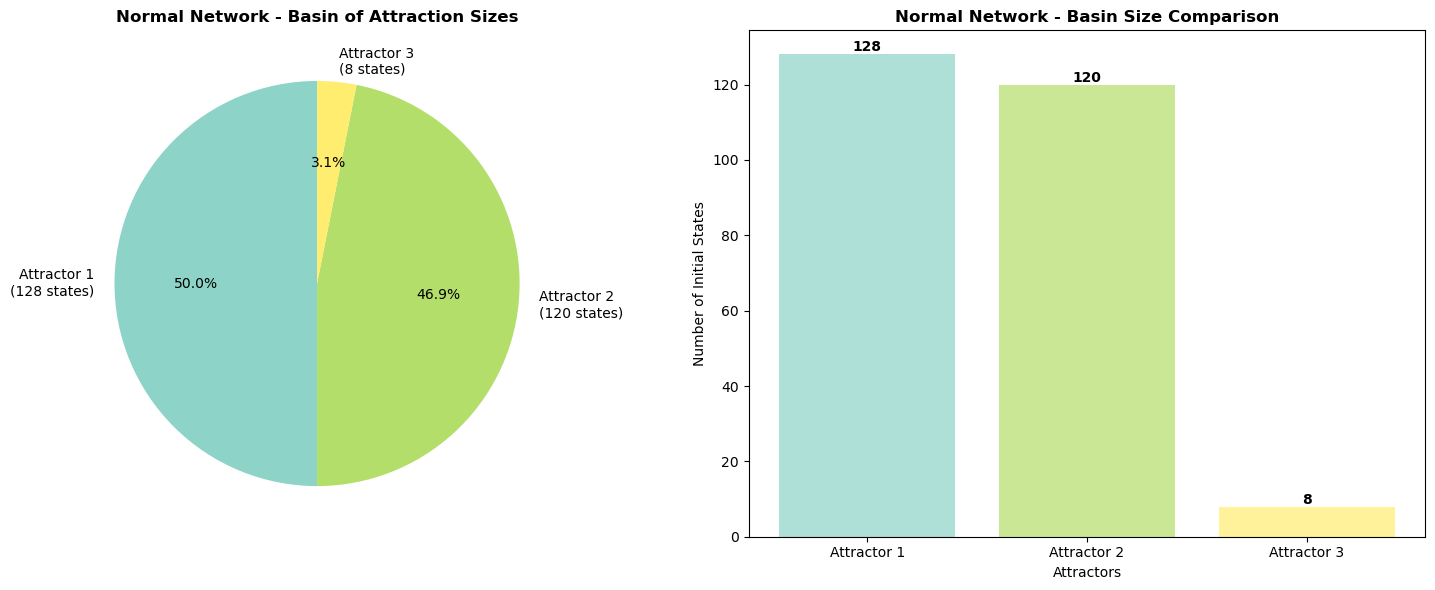

In [170]:
basin_analysis(network, graph_title, mutant_attractors, mutant_attractor_info)



### Observations:
There are 3 attractors for the normal network. As can be seen in from the attractor search graph these states are the following:

(1, 0, 0, 1, 1, 1, 0, 0): Healthy growth (no DNA damage, growth ON, death OFF, p53 OFF).  
(0, 1, 1, 0, 0, 0, 1, 1): Apoptotic/death state (DNA damage present, growth OFF, death ON, p53 ON).  
(1, 1, 0, 1, 1, 1, 0, 0): Cancer-like growth (DNA damage present, but growth ON, death OFF, p53 OFF).  


The third attactor is the only one that is cancer like, since DNA damage is present but the cell continues to divide abnormally, instead of dying like in attractor 2. In the first attractor there is no DNA damage present so the cells just grows normally. Luckily only 3.1% of the states result in a cancer like state.This number is so low because, in most initial states p53 activivates p21 and therfore surpressed MYC preventing growth. However in a few cases high initial MYC/MDM2 levels suppress p53 activation, allowing the cell to grow and blocking apoptosis. It is important to note that due to the way our functions are set up, it is shown that 53.1% of states end up cancerous. However, for the normal network, the first attractor is in fact healthy, eventhough p53 is turned off, it would be able to respond to cancerous growths in the future. For mutated networks this is not the case, thats why this attractor is by default classified as cancerous in our function, since it was built with the mutations in mind.



## Mutation A: p53 Knockout (Loss of Tumor Suppressor)

We now mutate the Boolean network by forcing `p53` OFF. This mimics a loss-of-function mutation frequently observed in cancers and lets us explore how robust the decision circuit is to losing this tumour suppressor.

In [171]:
#  Apply Mutation
p53_mutant = create_regulatory_network(p53_knockout=True) 
print(f"{p53_mutant.rules['p53']['description']}")



Rules:
  DNA_damage = INPUT (constant)
  p21 = p53
  MYC = (NOT p53) AND (NOT p21)
  CDK2 = MYC AND (NOT p21) AND (NOT p53)
  MDM2 = MYC
  p53 = BROKEN (always OFF)
  Growth = CDK2 AND MYC AND (NOT p53)
  Death = p53 AND DNA_damage AND (NOT Growth)
p53 = BROKEN (always OFF)


### Scenario Analysis Under Mutation A

Reuse the three practical scenarios to check how the fate decision changes when `p53` is permanently OFF.

  Healthy Cell: Growth=1, Death=0, p53=0
  Stressed Cell: Growth=1, Death=0, p53=0
  Oncogene Hijacked Cell: Growth=1, Death=0, p53=0


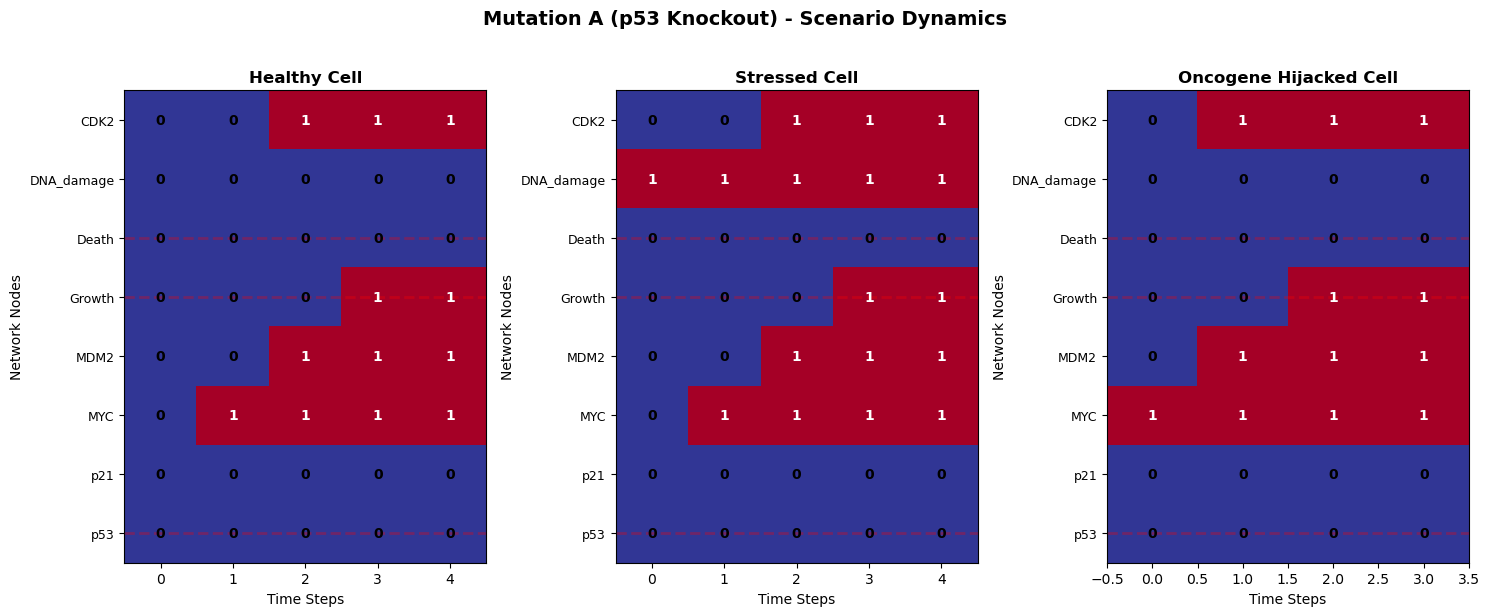

In [172]:
graph_title_a = 'Mutation A (p53 Knockout)'
scenario_analysis(p53_mutant, graph_title_a, 'p53')

### Attractor Analysis for Mutation A

Scan the full state space to see which steady states remain reachable and how often the network falls into cancer-like behaviour.

Testing all 256 possible initial states under Mutation of p53

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | p53: OFF | DNA Damage: OFF
   Interpretation: Cancer- like growth in healthy conditions

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | p53: OFF | DNA Damage: ON
   Interpretation: Cancer-like growth despite DNA damage


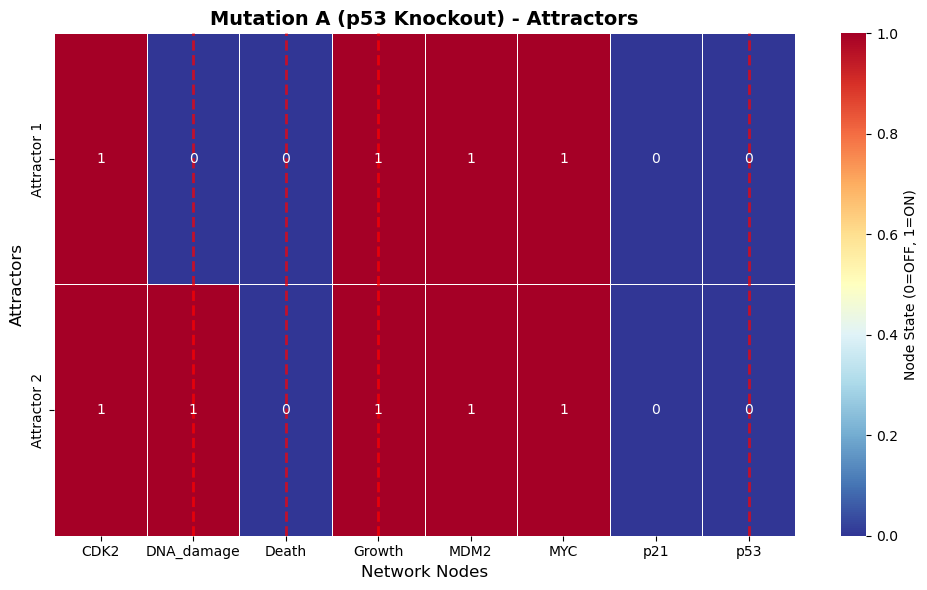

In [173]:
mutant_attractors, mutant_attractor_info = attractor_search(p53_mutant, graph_title_a, 'p53')


Basin sizes underMutation A (p53 Knockout):
  Attractor 1: 128 states ( 50.0%) -> Cancer- like growth in healthy conditions
  Attractor 2: 128 states ( 50.0%) -> Cancer-like growth despite DNA damage

Overall, 256 of 256 states (100.0%) flow into cancer-like attractors.


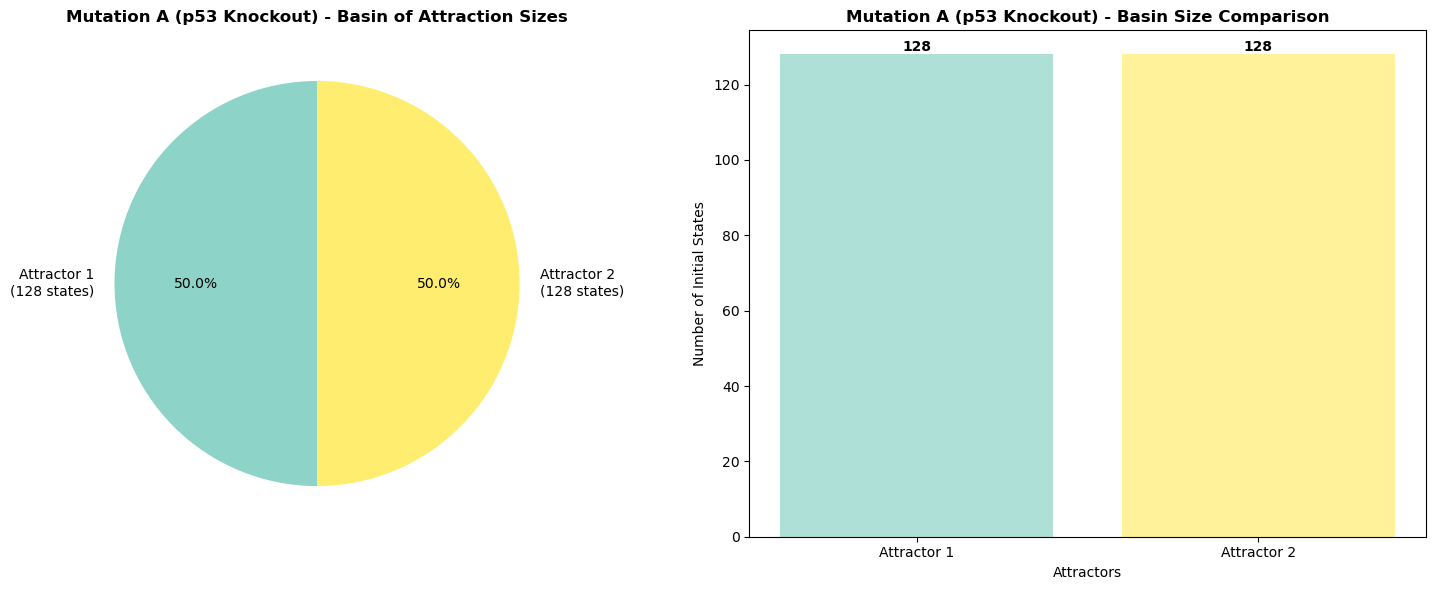

In [174]:
basin_analysis(p53_mutant, graph_title_a, mutant_attractors, mutant_attractor_info)

## Mutation B: MYC Amplification (Oncogene overexpression)
Now we mutate the Boolean network by forcing MYC permanently ON.
This mimics an oncogene amplification mutation frequently observed in cancers, where MYC is overexpressed due to gene amplification. As a result, the cell receives a constant “grow and divide” signal, even in the presence of DNA damage.



In [175]:
#  Apply Mutation
MYC_amplification = create_regulatory_network(MYC_amplification=True) 
print(f"{MYC_amplification.rules['MYC']['description']}")

Rules:
  DNA_damage = INPUT (constant)
  p21 = p53
  MYC = AMPLIFIED (always ON)
  CDK2 = MYC AND (NOT p21) AND (NOT p53)
  MDM2 = MYC
  p53 = DNA_damage AND (NOT MDM2)
  Growth = CDK2 AND MYC AND (NOT p53)
  Death = p53 AND DNA_damage AND (NOT Growth)
MYC = AMPLIFIED (always ON)


### Scenario Analysis Under Mutation B

Reuse the three practical scenarios to check how the fate decision changes when `MYC` is permanently ON.

  Healthy Cell: Growth=1, Death=0, MYC=1
  Stressed Cell: Growth=1, Death=0, MYC=1
  Oncogene Hijacked Cell: Growth=1, Death=0, MYC=1


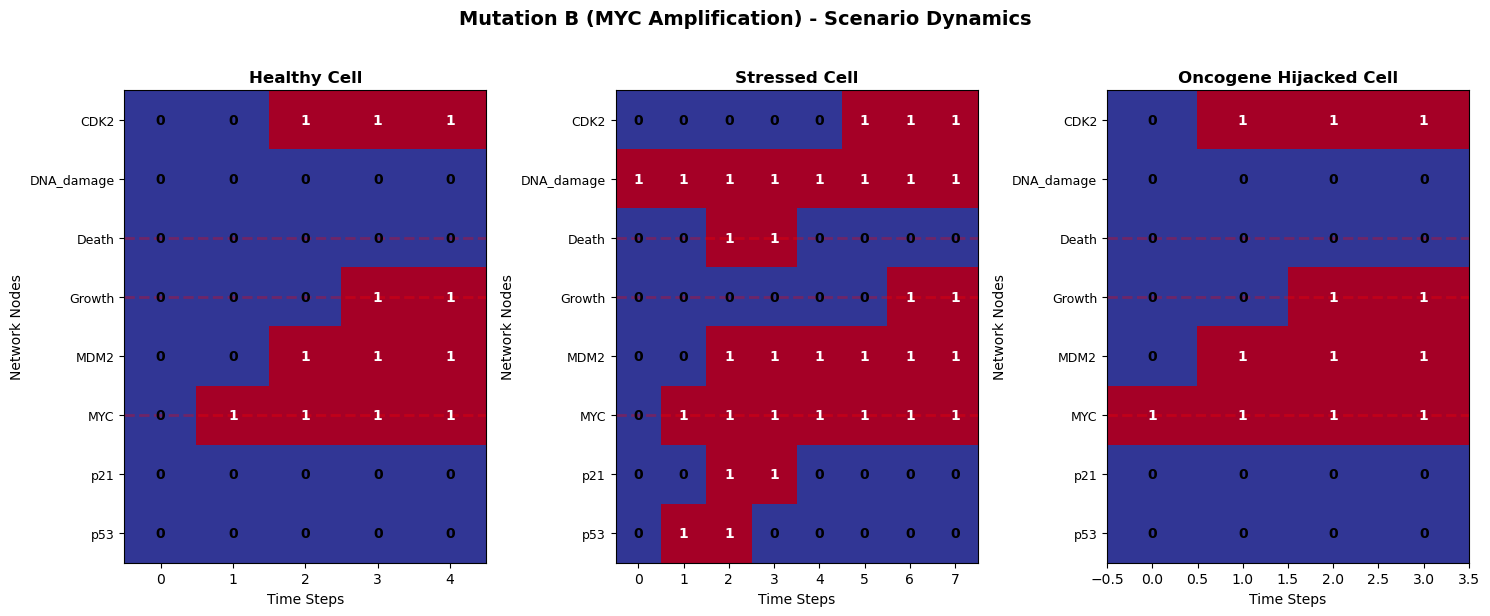

In [176]:
#  Scenario analysis with the MYC  Amplification
graph_title_b = 'Mutation B (MYC Amplification)'
scenario_analysis(MYC_amplification, graph_title_b, 'MYC')


### Attractor Analysis for Mutation B

Scan the full state space to see which steady states remain reachable and how often the network falls into cancer-like behaviour.

Testing all 256 possible initial states under Mutation of MYC

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | MYC: ON | DNA Damage: OFF
   Interpretation: Cancer- like growth in healthy conditions

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | MYC: ON | DNA Damage: ON
   Interpretation: Cancer-like growth despite DNA damage


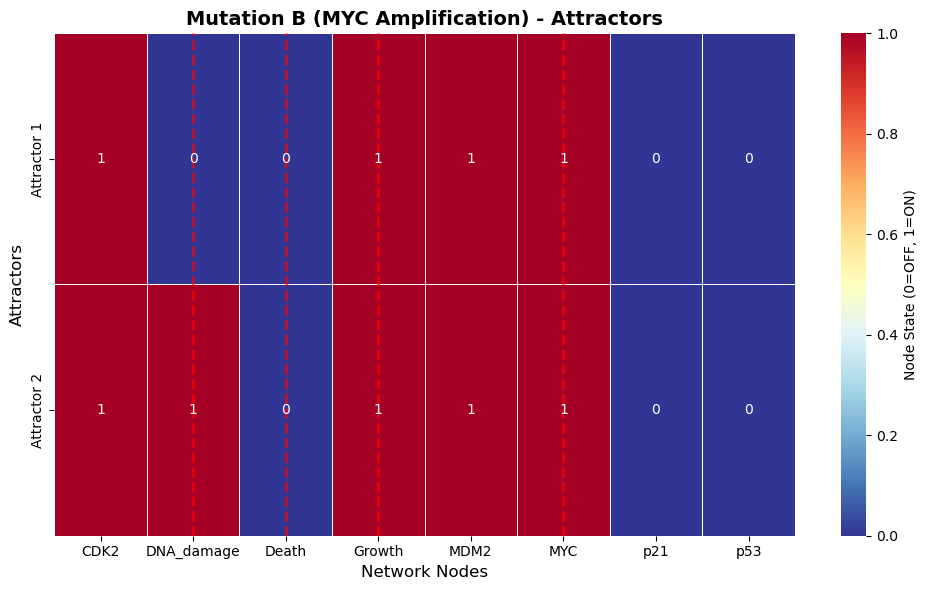

In [177]:
#  Attractor search for the myc amplification network
mutant_attractors, mutant_attractor_info = attractor_search(MYC_amplification, graph_title_b, 'MYC')


Basin sizes underMutation B (MYC Amplification):
  Attractor 1: 128 states ( 50.0%) -> Cancer- like growth in healthy conditions
  Attractor 2: 128 states ( 50.0%) -> Cancer-like growth despite DNA damage

Overall, 256 of 256 states (100.0%) flow into cancer-like attractors.


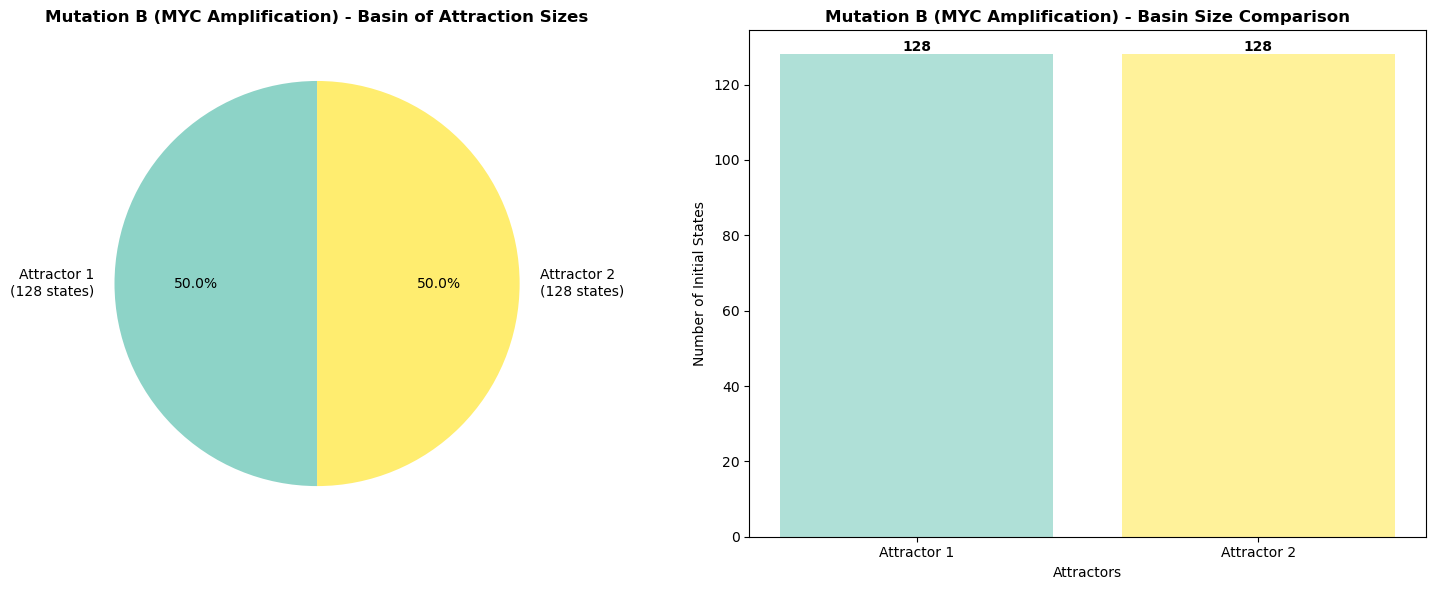

In [178]:
#  Basin analysis for Mutation B
basin_analysis(MYC_amplification, graph_title_b, mutant_attractors, mutant_attractor_info)

## Mutation C: MDM2 overexpression (p53 pathway disruption)
Now we mutate the Boolean network by making MDM2 overexpressed.

In [179]:
# Apply Mutation
MDM2_overexpression = create_regulatory_network(MDM2_overexpression=True) 
print(f"{MDM2_overexpression.rules['MDM2']['description']}")

Rules:
  DNA_damage = INPUT (constant)
  p21 = p53
  MYC = (NOT p53) AND (NOT p21)
  CDK2 = MYC AND (NOT p21) AND (NOT p53)
  MDM2 = OVEREXPRESSED (always ON)
  p53 = DNA_damage AND (NOT MDM2)
  Growth = CDK2 AND MYC AND (NOT p53)
  Death = p53 AND DNA_damage AND (NOT Growth)
MDM2 = OVEREXPRESSED (always ON)


### Scenario Analysis Under Mutation C

Reuse the three practical scenarios to check how the fate decision changes when `MDM2` is overexpressed.

  Healthy Cell: Growth=1, Death=0, MDM2=1
  Stressed Cell: Growth=1, Death=0, MDM2=1
  Oncogene Hijacked Cell: Growth=1, Death=0, MDM2=1


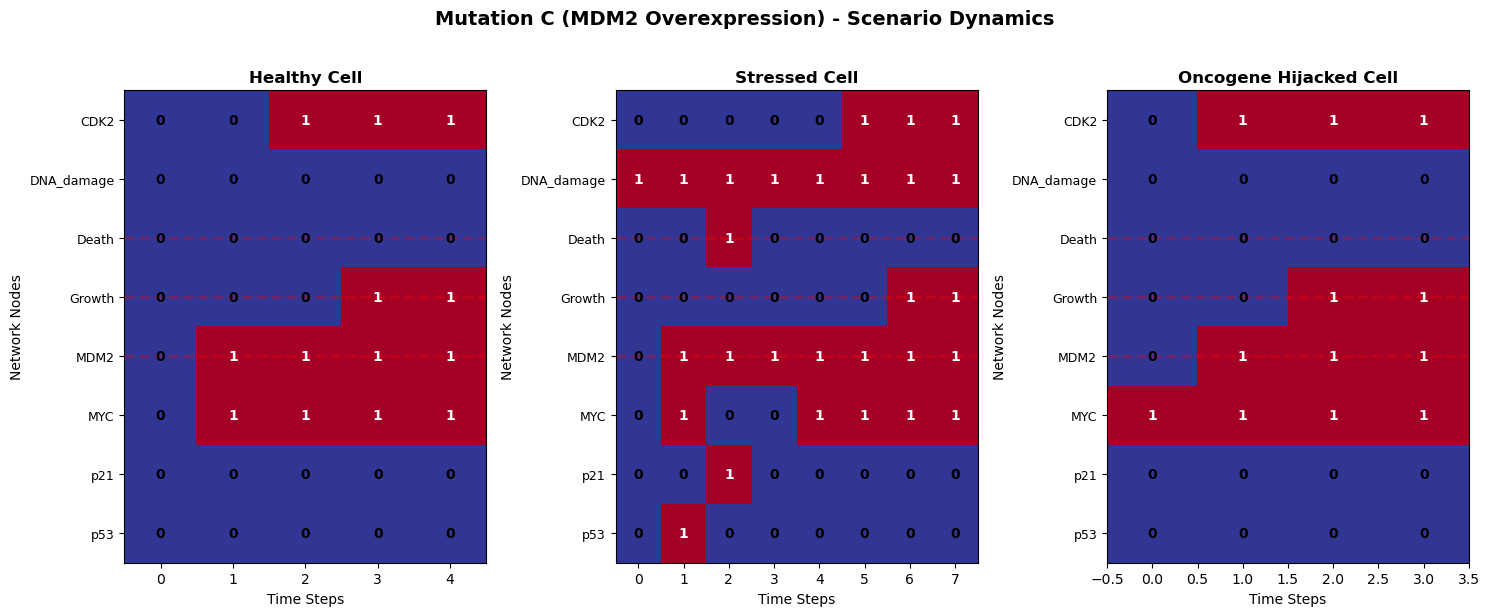

In [180]:
#  Scenario analysis with the MDM2 overexpression
graph_title_c = 'Mutation C (MDM2 Overexpression)'
scenario_analysis(MDM2_overexpression, graph_title_c, 'MDM2')

### Attractor Analysis for Mutation C

Scan the full state space to see which steady states remain reachable and how often the network falls into cancer-like behaviour.

Testing all 256 possible initial states under Mutation of MDM2

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | MDM2: ON | DNA Damage: OFF
   Interpretation: Cancer- like growth in healthy conditions

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | MDM2: ON | DNA Damage: ON
   Interpretation: Cancer-like growth despite DNA damage


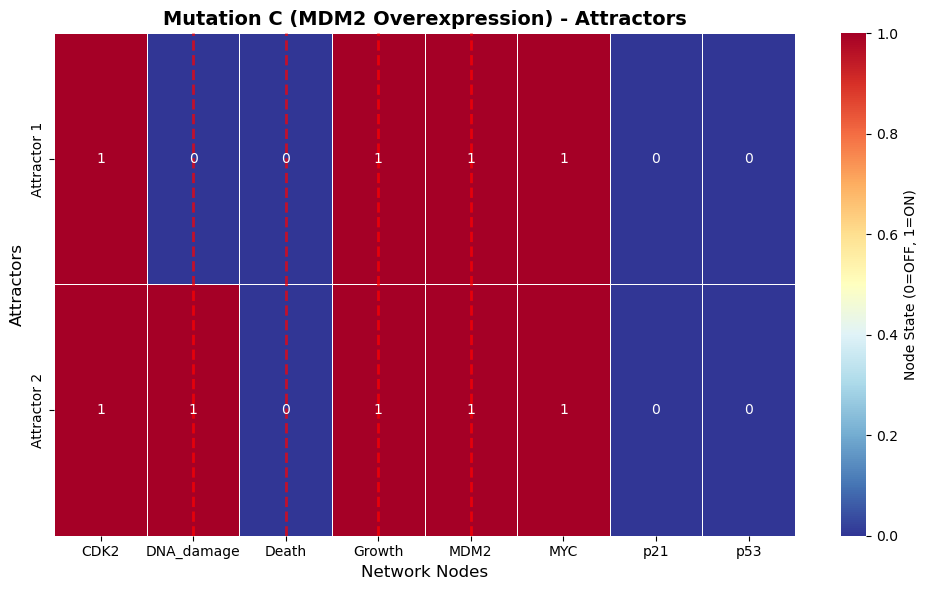

In [181]:
mutant_attractors, mutant_attractor_info = attractor_search(MDM2_overexpression, graph_title_c, 'MDM2')


Basin sizes underMutation C (MDM2 Overexpression):
  Attractor 1: 128 states ( 50.0%) -> Cancer- like growth in healthy conditions
  Attractor 2: 128 states ( 50.0%) -> Cancer-like growth despite DNA damage

Overall, 256 of 256 states (100.0%) flow into cancer-like attractors.


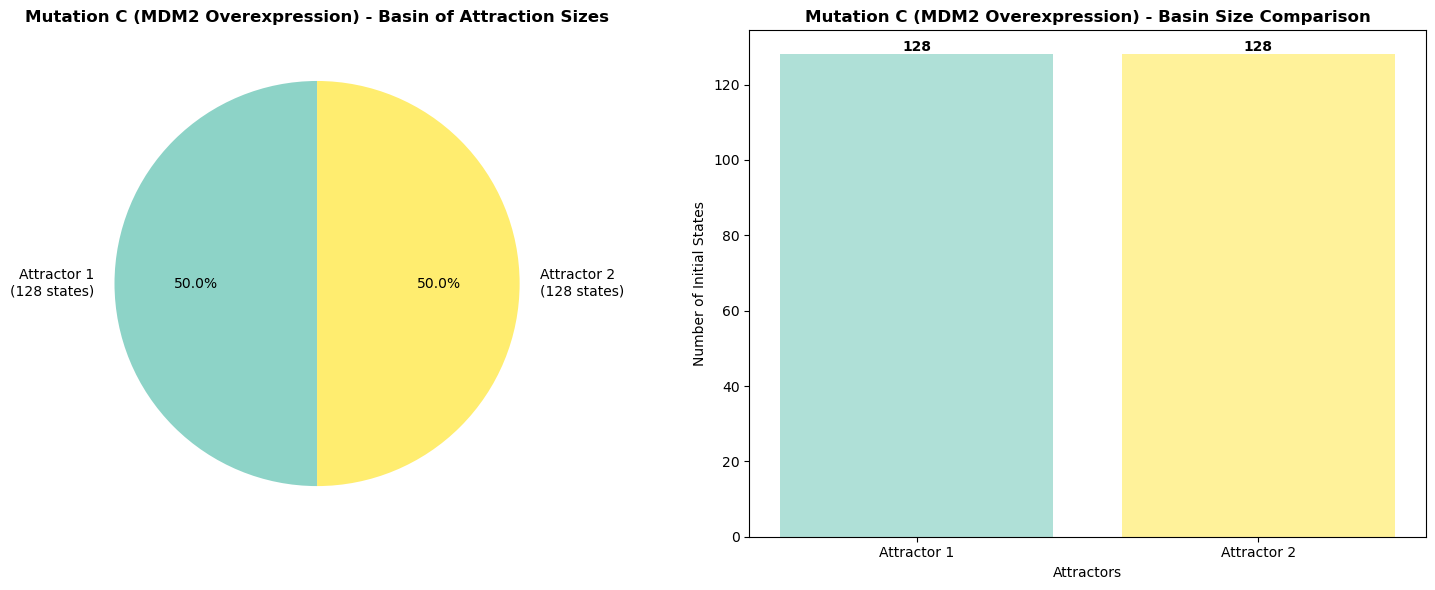

In [182]:
basin_analysis(MDM2_overexpression, graph_title_c, mutant_attractors, mutant_attractor_info)

### Observations for Mutations A, B and C:
All 3 mutations only have 2 possible attractors, namely:

(1, 0, 0, 1, 1, 1, 0, 0): Growth ON, no DNA damage, death OFF, p53 OFF.   
(1, 1, 0, 1, 1, 1, 0, 0): Growth ON, DNA damage present, death OFF, p53 OFF (cancer-like, ignoring damage). 

All 3 of these mutatuions disrupt the p53-mediated apoptosis pathway in similar ways:

p53 always OFF (Mutation A): p53 can't activate (p21 stays OFF, no brake on growth). MYC/CDK2/Growth go ON, MDM2 follows MYC (ON), Death stays OFF. So there is no way to trigger apoptosis.   

MYC always ON (Mutation B): Forces MDM2 ON (since MDM2 = MYC), which suppresses p53 (p53 = DNA_damage AND NOT MDM2 → always OFF if MDM2=1). p21 stays OFF, CDK2/Growth go ON, Death OFF.  Again no way for the cell to die, and there is unlimited growth.

MDM2 always ON (Mutation C): Directly suppresses p53, same as mutation b. MYC goes ON (no p53/p21 inhibition), CDK2/Growth ON, Death OFF.


In all cases, the network is stuck in uncontrolled growth. The only difference between the two attractors is if there is DNA damage or not, which doesn't affect the outputs because p53 can't respond. These mutations basically disable the cell's safety mechanisms, leading to cancer-like growth in both cases.

## Mutation D(OUR CHOICE): CDK2 Knockout
Now we mutate the Boolean network by knocking out CDK2.(Tumour suppressor therapies aim to inactivate CDKs, expected effect would be that it blocks Growth regardless of MYC/p53 state)

In [183]:
## apply mutation
CDK2_mutant = create_regulatory_network(CDK2_knockout = True)
print(f"{CDK2_mutant.rules['CDK2']['description']}")

Rules:
  DNA_damage = INPUT (constant)
  p21 = p53
  MYC = (NOT p53) AND (NOT p21)
  CDK2 = KNOCKOUT (always OFF)
  MDM2 = MYC
  p53 = DNA_damage AND (NOT MDM2)
  Growth = CDK2 AND MYC AND (NOT p53)
  Death = p53 AND DNA_damage AND (NOT Growth)
CDK2 = KNOCKOUT (always OFF)


### Scenario Analysis Under Mutation D

Reuse the three practical scenarios to check how the fate decision changes when we knokout CDK2

  Healthy Cell: Growth=0, Death=0, CDK2=0
  Stressed Cell: Growth=0, Death=1, CDK2=0
  Oncogene Hijacked Cell: Growth=0, Death=0, CDK2=0


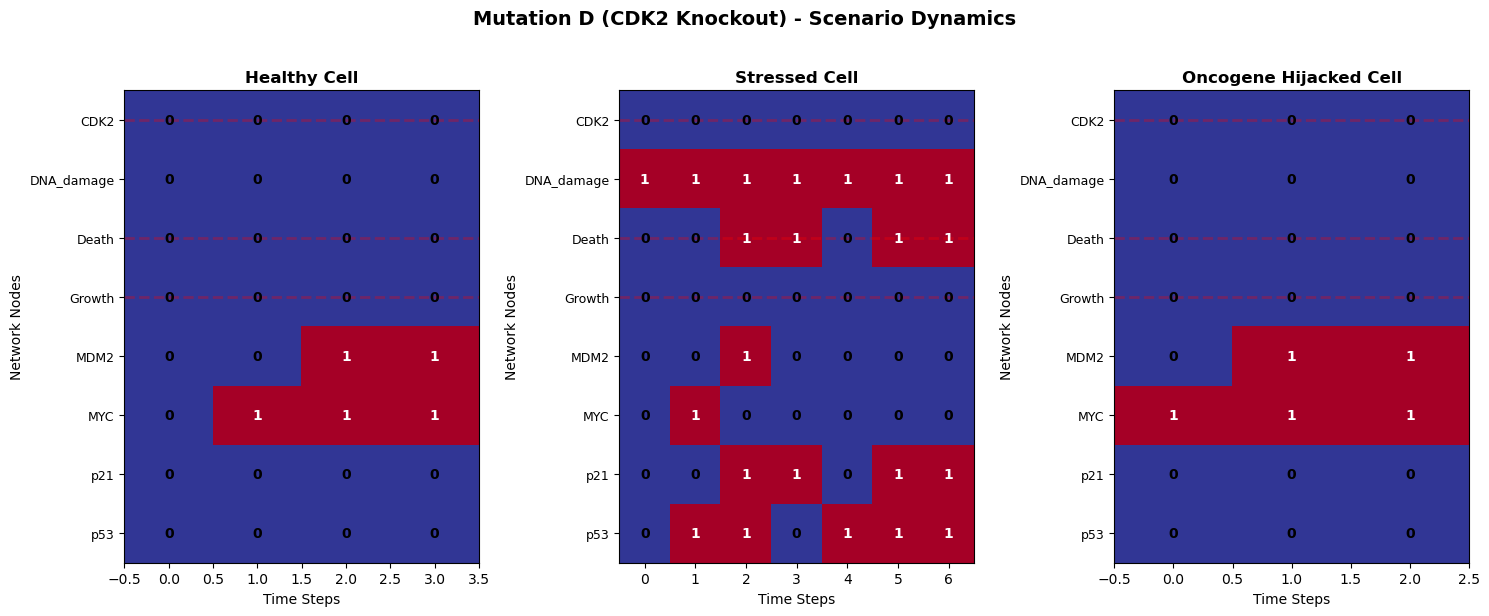

In [184]:
graph_title_d = 'Mutation D (CDK2 Knockout)'
scenario_analysis(CDK2_mutant, graph_title_d, 'CDK2')

### Attractor Analysis for Mutation D

Scan the full state space to see which steady states remain reachable and how often the network falls into cancer-like behaviour.

Testing all 256 possible initial states under Mutation of CDK2

Attractor 1: [0, 0, 0, 0, 1, 1, 0, 0]
   Growth: OFF | Death: OFF | CDK2: OFF | DNA Damage: OFF
   Interpretation: Quiescent or unresolved state

Attractor 2: [0, 1, 1, 0, 0, 0, 1, 1]
   Growth: OFF | Death: ON | CDK2: OFF | DNA Damage: ON
   Interpretation: Cell death / apoptosis

Attractor 3: [0, 1, 0, 0, 1, 1, 0, 0]
   Growth: OFF | Death: OFF | CDK2: OFF | DNA Damage: ON
   Interpretation: Quiescent or unresolved state


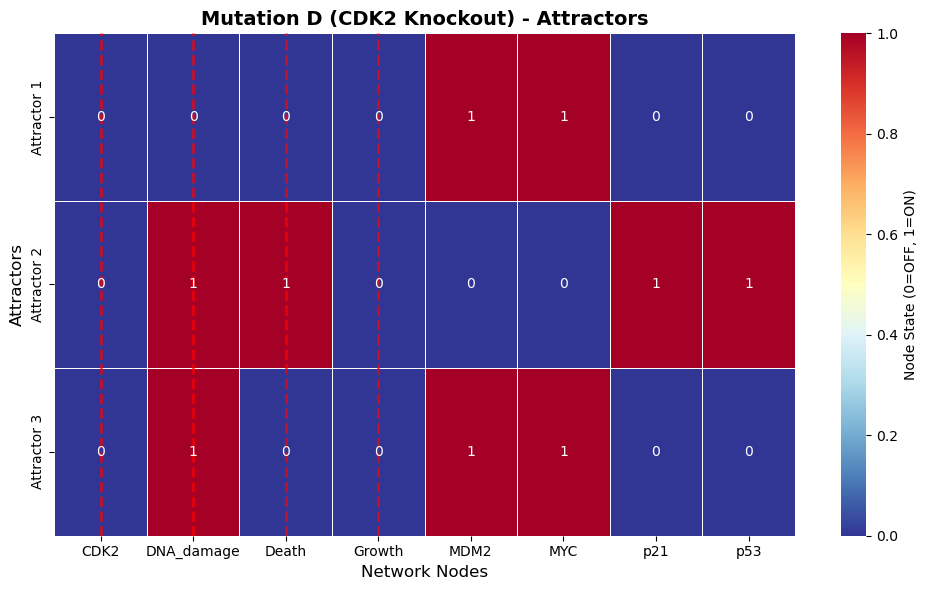

In [185]:
mutant_attractors, mutant_attractor_info = attractor_search(CDK2_mutant, graph_title_d, 'CDK2')


Basin sizes underMutation D (CDK2 Knockout):
  Attractor 1: 128 states ( 50.0%) -> Quiescent or unresolved state
  Attractor 2: 120 states ( 46.9%) -> Cell death / apoptosis
  Attractor 3:   8 states (  3.1%) -> Quiescent or unresolved state

Overall, 0 of 256 states (  0.0%) flow into cancer-like attractors.


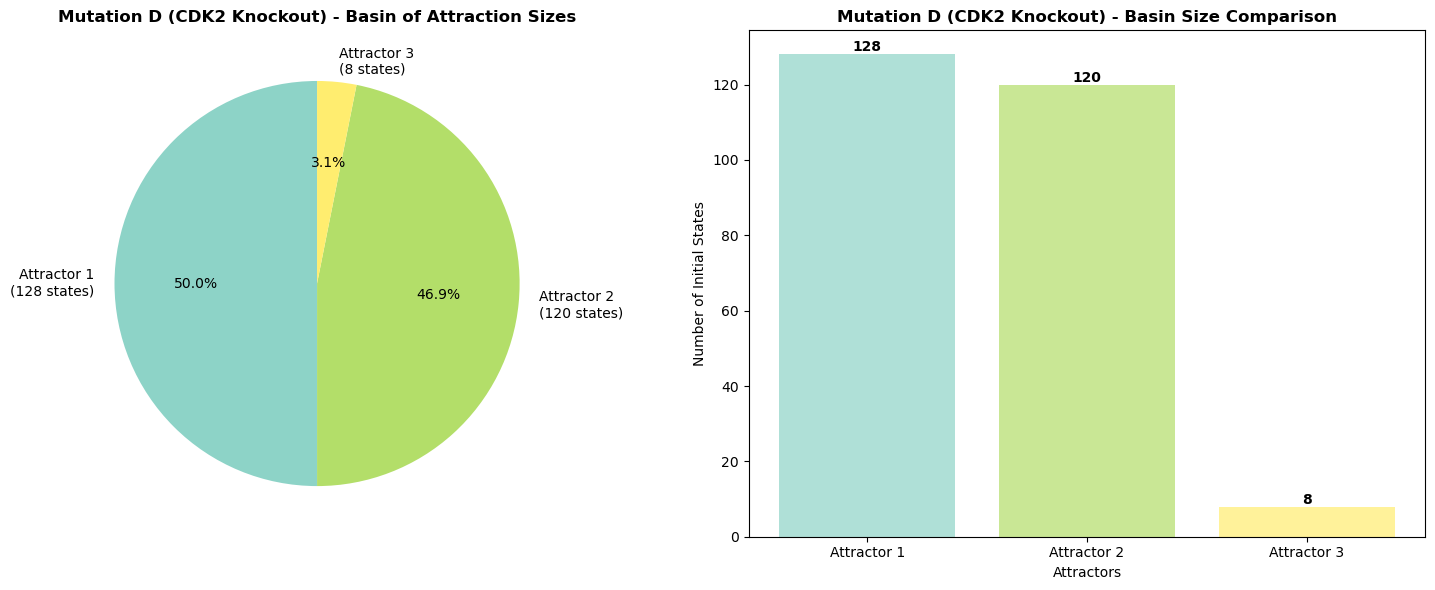

In [186]:
basin_analysis(CDK2_mutant, graph_title_d, mutant_attractors, mutant_attractor_info)

### Observations for Mutation D (CDK2 Knockout):
This mutation has 3 possible attractors, namely:

(0, 0, 0, 0, 1, 1, 0, 0): Growth OFF, no DNA damage, death OFF, p53 OFF (quiescent state with MYC/MDM2 ON but no proliferation due to CDK2 loss).  
(0, 1, 1, 0, 0, 0, 1, 1): Growth OFF, DNA damage present, death ON, p53 ON (apoptotic response to damage, with p21 ON and MYC/MDM2 suppressed).  
(0, 1, 0, 0, 1, 1, 0, 0): Growth OFF, DNA damage present, death OFF, p53 OFF (unresolved state, with MYC/MDM2 ON suppressing p53, but no proliferation).

CDK2 knockout (always OFF) disrupts the cell cycle progression pathway:  

CDK2 is a key driver of cell division (Growth = CDK2 AND MYC), so forcing it OFF prevents Growth in all states, regardless of other signals. This leaves the p53-apoptosis pathway largely intact, similar to the wild-type network, but the ability to grow is impaired. MYC can still drive MDM2 (MDM2 = MYC), allowing suppression of p53 in specific initial conditions, while DNA_damage acts as a persistent input that triggers p53 (if not suppressed) leading to p21 ON and potential Death, this happens in 46.9% of cases. If the cell does not die, it is in a quiescent state.